## Preparing Data for Modeling

In [1]:
%cd ..

c:\Users\nirul\repos\Housing-End-to-End


In [2]:
import sys
import os

# Set the project root path
project_root = r"C:\Users\nirul\repos\Housing-End-to-End"

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)



In [3]:
# DATA CLEANING
import pandas as pd
from src.data_preprocessing import etl_pipeline

# Load the dataset
data = pd.read_csv(r"C:\Users\nirul\repos\Housing-End-to-End\dataset\modified_housing.csv")

X, y = etl_pipeline(data,'median_house_value', ordinal_encoding=True)




## Select and Train the Model

In [4]:
from sklearn.linear_model import LinearRegression
from src.model import eval_model

linear_model = LinearRegression()

eval_model(X,y,linear_model,"r")



Model LinearRegression(Regression)
Predictions [ 88344.83375402 295416.02641591 169047.43394186 ... 214809.52784089
 227842.00117337  92849.85233604]
Root Mean Squared Error 68833.92175295758
Mean Absolute Error 49841.508102780215
R^2 0.6460394399951755


Since most districts’ `median_housing_values` range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data.

The main ways to fix underfitting are:
- To select a more powerful model
- To feed the training algorithm with better features
- or to reduce the constraints on the model.

Let us try the first step - to select a more powerful model. Let us use a `DecisionTreeRegressor`


In [5]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
eval_model(X,y,tree_reg,"r")

Model DecisionTreeRegressor(Regression)
Predictions [ 72100. 279600.  82700. ... 140400. 258100.  62700.]
Root Mean Squared Error 0.0
Mean Absolute Error 0.0
R^2 1.0


This is a case of overfitting the data.

In [6]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
eval_model(X,y,forest_reg,"r")

Model RandomForestRegressor(Regression)
Predictions [ 75298.   293640.01  86144.   ... 156805.   250639.03  71657.  ]
Root Mean Squared Error 18780.419568941783
Mean Absolute Error 12111.95164304748
R^2 0.9736512251205067


Much better !

## Cross- Validation

Cross-validation is a technique used to evaluate the performance of a machine learning model by splitting the data into multiple subsets (folds). The model is trained on some folds and tested on the remaining fold(s), and this process is repeated multiple times to ensure the model's performance is consistent and not overfitted to a particular subset.

In [7]:
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor()

cv_scores = cross_val_score(model, X, y, cv=5)  # cv=5 means 5-fold cross-validation

# Print the cross-validation scores for each fold
print("Cross-validation scores for each fold:", cv_scores)

# Print the mean and standard deviation of the scores
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV scores: {cv_scores.std():.4f}")

Cross-validation scores for each fold: [0.8062131  0.81018119 0.8082221  0.78970336 0.80911677]
Mean CV score: 0.8047
Standard deviation of CV scores: 0.0076


This means that the model is able to explain 80.47% of the variance in `median_house_value` and since the standard dev is very low 0.0076, it means the model performance is stable across all folds. This means the model generalizes well.

## Hyperparameter Tuning (Fine-Tuning Your Model)

#### GridSearch 

It searches for the best combination of hyperparamters

For example, in the following code, `param_grid` tells Scikit-Learn to try 12 combinations of the `n_estimators` and `max_features` hyperparameters (3 values for `n_estimators` and 4 for `max_features`). Then, it will test 6 combinations of other hyperparameters. So, in total, Scikit-Learn will explore 18 combinations of hyperparameters. Since we are using 5-fold cross-validation, it will train each model 5 times, resulting in 90 rounds of training (18 combinations × 5 folds).

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [   {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
   {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
   ] 
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,   scoring='neg_mean_squared_error',   return_train_score=True) 
grid_search.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

 It is found that a `RandomForestRegressor` using `4 features` and `30 trees` gave the best results

In [10]:
# Get the best model
best_model = grid_search.best_estimator_

eval_model(X,y,best_model,task="r")




Model RandomForestRegressor(Regression)
Predictions [ 73066.66666667 284990.          84350.         ... 162636.66666667
 233416.66666667  73130.        ]
Root Mean Squared Error 19551.982856939263
Mean Absolute Error 12534.496186611757
R^2 0.971441758525006


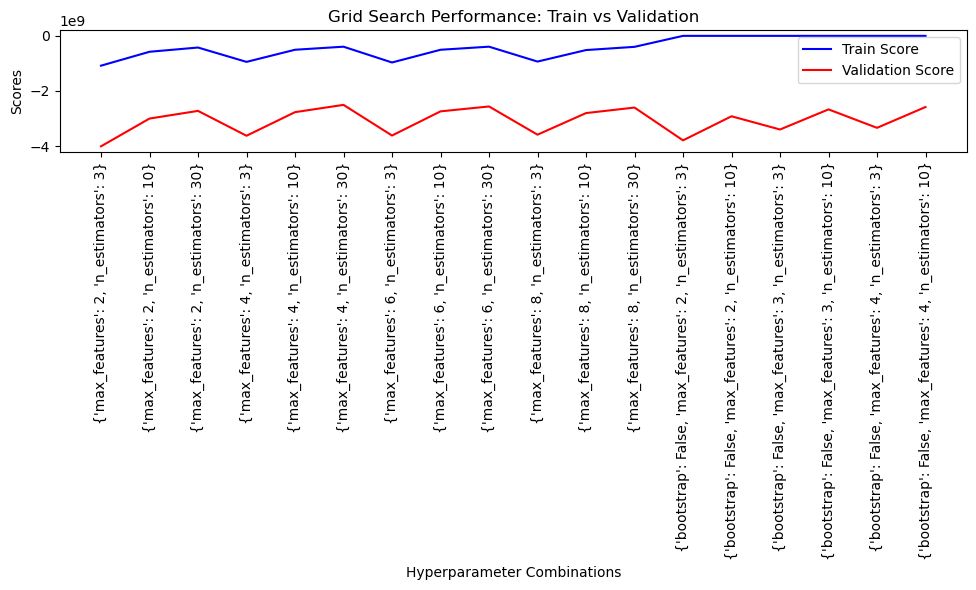

In [12]:
# Plot training and validation scores vs hyperparameter combinations
import matplotlib.pyplot as plt
import numpy as np

results = grid_search.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(results['mean_train_score'], label='Train Score', color='blue')
plt.plot(results['mean_test_score'], label='Validation Score', color='red')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Scores')
plt.title('Grid Search Performance: Train vs Validation')
plt.legend()
plt.xticks(np.arange(len(results['mean_test_score'])), results['params'], rotation=90)
plt.tight_layout()
plt.show()

## Run the Model on Test Data

X_test = strat_test_set.drop()